In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import gymnasium as gym
import numpy as np

env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)



Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [23]:
def custom_reward(episode_len, reward, terminated, truncated):

    # print(episode_len, reward, terminated, truncated)
    if episode_len > 20 or truncated:
        return 1
    
    elif terminated:
        return -1
    
    else:
        return 0

In [26]:
dataset = []

next_obs, info = env.reset()

curr_episode = []
episode_len = 0

for _ in range(1000):
    episode_len += 1
    obs = next_obs
    action = env.action_space.sample()  # agent policy that uses the observation and info
    next_obs, reward, terminated, truncated, info = env.step(action)
    reward = custom_reward(episode_len, reward, terminated, truncated)
    curr_episode += [obs, action, reward]

    # print([obs, action, reward])
    if reward != 0:
        dataset.append(curr_episode) # instead of appending (S, A, R, S, A) tuples I can append a stream of S, A, R, S, A, R, S, A, R, much more compact!
        curr_episode = []
        episode_len = 0
        next_obs, info = env.reset()

# env.close()

print(dataset[0])
print("num of trajecotries: ", len(dataset))

# sentence -> trajectory
# word -> action chunk (grasp, go_to, lift)
# character -> muscle twich (basic unit of the trajectory)

# How to model this problem? that is the real question!!!!
# Mabye I put it all into one high dimensional vector?

# Learning a world model like this should be straight forward? Not learning about what action comes next. given this observation and this action, what happens next?
# Why we didn't worry about this till now, is beacuse we assumed the world was markovian. Current state is enough to make the right decisions, so it's inpdenent from previous states

# If we encode each state as it is in the moment, how can you learn about the differences? Well you could subtract...

# How many tokens? Characters....

# A picture is worth 1000 words... at every 10s you have 1000 words...


[array([-0.02369116,  0.03549241, -0.01495367, -0.04904135], dtype=float32), 0, 0, array([-0.02298131, -0.15941197, -0.0159345 ,  0.23888631], dtype=float32), 0, 0, array([-0.02616955, -0.3543027 , -0.01115677,  0.52650076], dtype=float32), 1, 0, array([-0.0332556 , -0.15902555, -0.00062675,  0.23032324], dtype=float32), 1, 0, array([-0.03643611,  0.03610535,  0.00397971, -0.06255732], dtype=float32), 0, 0, array([-0.035714  , -0.15907343,  0.00272856,  0.23137857], dtype=float32), 1, 0, array([-0.03889547,  0.03600942,  0.00735614, -0.06044243], dtype=float32), 1, 0, array([-0.03817528,  0.23102513,  0.00614729, -0.3507954 ], dtype=float32), 1, 0, array([-0.03355478,  0.42605913, -0.00086862, -0.64153355], dtype=float32), 0, 0, array([-0.0250336 ,  0.2309493 , -0.01369929, -0.3491243 ], dtype=float32), 1, 0, array([-0.02041462,  0.4262634 , -0.02068178, -0.6460954 ], dtype=float32), 0, 0, array([-0.01188935,  0.23143563, -0.03360369, -0.3599963 ], dtype=float32), 0, 0, array([-0.00726

In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


Alot of this work is to make discrete variables work. For robots, we don't have that many discrete variables though... perhaps if you want to be able to take text commands. Torque values are already conceputally smooth. ie a value of 0.9 is similar to 1.0.

In [7]:
# Tokenizer - convert words into numbers for computer

char_to_int = dict()
int_to_char = dict()

for i in range (len(chars)):
    char_to_int[chars[i]] = i
    int_to_char[i] = chars[i]

print(char_to_int)
print(int_to_char)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

In [59]:
data = []
for char in text:
    data.append(char_to_int[char])

data = torch.tensor(data)
print(len(data))
data[:10]

1115393


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])

In [60]:

split_idx = int(len(data)*0.8)
train_data = data[:split_idx]
val_data = data[split_idx:]
print(len(train_data))
print(len(val_data))


892314
223079


In [61]:

batch_size = 4 
context_length = 8

# How to slice? 
# take random 8 sequnces, take every 8, take every 1

# Ok Andrej takes random sequences, one reason this may be smart is beacuse backprop excepts IID samples, If you put in many consquetive samples 
# Then you are back in the RL example, and gradient descent may have troubles...


def get_batch(n = 4, type = "train"):
    if type == "train":
        data = train_data

    elif type == "val":
        data = val_data

    data_len = len(data) - context_length
    ix = torch.randint(data_len, size=(n,))

    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+1+context_length] for i in ix])

    return x, y

x, y = get_batch()

print(x,y)

for i in range(context_length):
    print(f"input: {x[0,:i+1]} target: {y[0,i]}")


tensor([[52, 45,  1, 32, 63, 40, 39, 50],
        [37, 53, 59,  1, 39, 56, 43,  1],
        [52, 43,  6,  1, 21,  5, 50, 50],
        [ 1, 61, 47, 58, 46,  1, 49, 47]]) tensor([[45,  1, 32, 63, 40, 39, 50, 58],
        [53, 59,  1, 39, 56, 43,  1, 41],
        [43,  6,  1, 21,  5, 50, 50,  1],
        [61, 47, 58, 46,  1, 49, 47, 52]])
input: tensor([52]) target: 45
input: tensor([52, 45]) target: 1
input: tensor([52, 45,  1]) target: 32
input: tensor([52, 45,  1, 32]) target: 63
input: tensor([52, 45,  1, 32, 63]) target: 40
input: tensor([52, 45,  1, 32, 63, 40]) target: 39
input: tensor([52, 45,  1, 32, 63, 40, 39]) target: 50
input: tensor([52, 45,  1, 32, 63, 40, 39, 50]) target: 58


In [145]:
# I need a network that goes from 1-8 inputs (actually always 8, sometimes we can just fill in with empty characters, or mask?)
# to 1 output, which is the next character.


class Model(torch.nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.vocab_size = vocab_size
        self.linear1 = torch.nn.Linear(self.vocab_size, self.vocab_size)

    def forward(self, x, y=None):
        
        x_encoded = F.one_hot(x, num_classes=self.vocab_size).float()
        logits = self.linear1(x_encoded)

        if y == None:
            loss = None
        else:
            B, T, C = logits.shape #Batch, Time, Classes
            logits_flat = logits.view(B*T, C)
            y = y.view(B*T)
            loss = F.cross_entropy(logits_flat, y)

        return logits, loss
    
    def generate(self, prompt, max_response_len):
        for _ in range(max_response_len):
            logits, loss = self.forward(prompt)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)

            next_token = torch.multinomial(probs, num_samples=1)
            prompt = torch.cat((prompt, next_token), dim=1)

        return prompt

In [146]:
m = Model(65)

In [147]:
# 65 classes....
p = 1/65
print(-torch.log(torch.tensor([p])))

tensor([4.1744])


In [148]:
logits, loss = m.forward(x, y)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.2065, grad_fn=<NllLossBackward0>)


In [149]:
logits, loss = m.forward(torch.zeros((1,1), dtype=torch.long))
print(logits.shape)


torch.Size([1, 1, 65])


In [162]:
response = m.generate(prompt= torch.zeros((1,1), dtype=torch.long), max_response_len=100)

data = ''.join([int_to_char[v.item()] for v in response[0]])
data

#Pure randomness, but structure can be found... simply by looking at probabilites, conditioned on state...

"\npSKTLYxZwmb;co\nloJXeJmqnZOW'&JDATqZ,GF PuK:-n$M!BjkDXoa:D:bsMJMvt&nFvqicchNBAdIkHRcT\ntzKt$zgTmbF$:\nL"

If we apply this to robot use case... there is alot of structure in the world. You would see that most things don't change, ie newtons 2nd law, things that are still tend to stay still, things that are in motion tend to stay in motion, unless there is another force, you would understand acceleration, velocity, position. You could build a mental model of occulusion, and 3d space. You could understand objects, that things can seperate.

One problem may be that the attention is very low dimensionsal... One node may have alot of information for text, but not really for high dimensional input...

People have started to look into spatial attention:

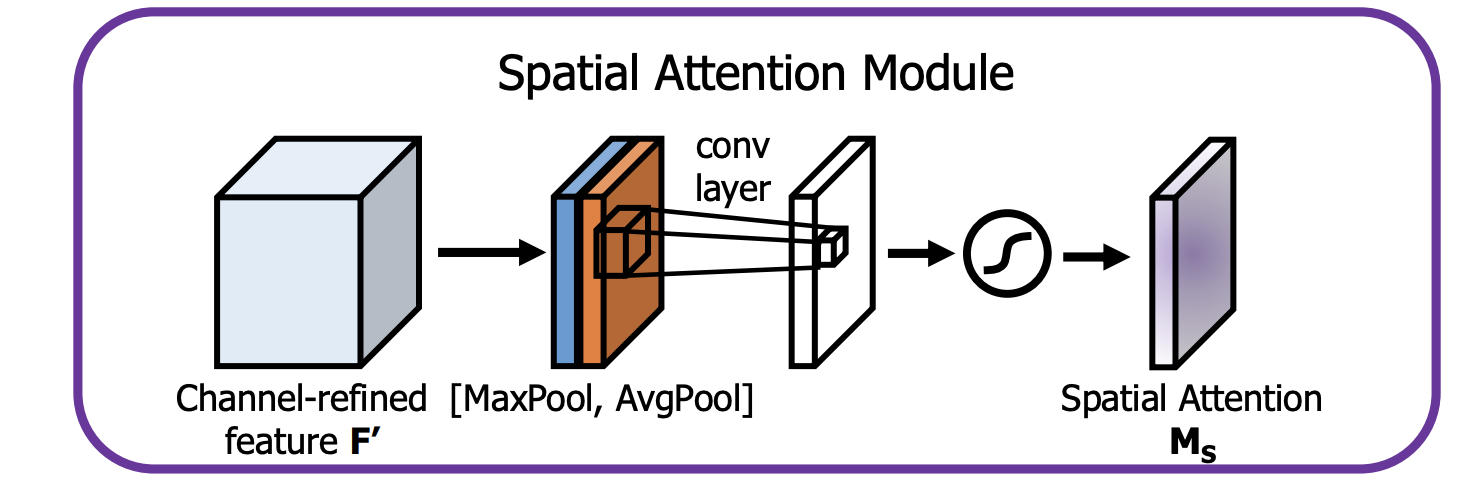

In [ ]:
for i in range(1):
    X, Y = get_batch(x, y)
    logits, loss = m.forward(x, y)

    